# PRODUCT PROPENSITY - PROD - Redshift - Canucks Data
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* July 14, 2022

## Hypothesis
This notebook will test the Product Propensity model features and the goal is to check how the accuracy and scores look when we train the model only with Canucks data compared to all NHL data.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [8]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from shared_utilities import helpers
from pycaret.classification import *

In [9]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

LBVL-BFBD
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [10]:
conn = helpers.get_redshift_connection('prod-app', 'stlrcanucks')

In [11]:
# call the stored proc to get data for the retention model
cur = conn.cursor()
cur.execute(f"CALL ds.getproductpropensitymodeldata(7,2010, 2022, 'temp_cursor')")

# create a named cursor based on the cursor name passed in above
named_cursor = conn.cursor('temp_cursor')
data = named_cursor.fetchall()

# load the data and columns into a data frame
cols = [row[0] for row in named_cursor.description]
df = pd.DataFrame(data=data, columns=cols)

conn.commit()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1089728 entries, 0 to 1089727
Data columns (total 13 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   lkupclientid         1089728 non-null  int64  
 1   clientcode           1089728 non-null  object 
 2   dimcustomermasterid  1089728 non-null  int64  
 3   distance             1089728 non-null  float64
 4   seasonyear           1089728 non-null  int64  
 5   events_prior         1089728 non-null  int64  
 6   attended_prior       1089728 non-null  int64  
 7   events_last          1089728 non-null  int64  
 8   attended_last        1089728 non-null  int64  
 9   tenure               1089728 non-null  int64  
 10  atp_last             1089728 non-null  float64
 11  product_current      1089728 non-null  object 
 12  product_last         1089728 non-null  object 
dtypes: float64(2), int64(8), object(3)
memory usage: 108.1+ MB


In [13]:
# choose the features for the stellar base retention model
features = [
    "lkupclientid",
    "clientcode",
    "dimcustomermasterid", 
    "distance",
    "seasonyear",
    "events_prior",
    "attended_prior",
    "events_last",
    "attended_last",
    "tenure",
    "atp_last",
    "product_current",
    "product_last"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["seasonyear"] = pd.to_numeric(df_dataset["seasonyear"])
df_dataset = df_dataset.loc[df_dataset["seasonyear"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (594290, 13)
Unseen Data For Predictions: (104875, 13)



In [14]:
setup(
    data= df_train, 
    target="product_current", 
    train_size = 0.85,
    data_split_shuffle=True,
    silent=True,
    verbose=False,
    ignore_features=[
        "lkupclientid",
        "clientcode",
        "dimcustomermasterid",
        "seasonyear"
    ],
    numeric_features=[
        "distance",
    "events_prior",
    "attended_prior",
    "events_last",
    "attended_last",
    "tenure",
    "atp_last"
    ]
);

In [15]:
model_matrix = compare_models(
    fold=10,
    include=["rf"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9293,0.7819,0.4337,0.9016,0.9132,0.4227,0.4428,17.1140


In [16]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9289,0.7776,0.4204,0.9014,0.9128,0.4179,0.4384
1,0.9293,0.7861,0.4396,0.9016,0.9133,0.4262,0.4454
2,0.9301,0.7816,0.4447,0.9021,0.9137,0.4260,0.4473
3,0.9290,0.7808,0.4422,0.9015,0.9134,0.4279,0.4457
4,0.9282,0.7831,0.4370,0.9002,0.9122,0.4159,0.4350
5,0.9305,0.7825,0.4295,0.9023,0.9141,0.4282,0.4501
6,0.9296,0.7810,0.4353,0.9019,0.9134,0.4232,0.4441
7,0.9291,0.7845,0.4341,0.9020,0.9131,0.4224,0.4420
8,0.9286,0.7753,0.4316,0.9016,0.9127,0.4179,0.4373
9,0.9294,0.7868,0.4231,0.9012,0.9131,0.4217,0.4423


In [17]:
df_inference = df.loc[df["seasonyear"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(390563, 13)

In [18]:
new_predictions = predict_model(final_model, data=df_inference)
new_predictions.head()

,lkupclientid,clientcode,dimcustomermasterid,distance,seasonyear,events_prior,attended_prior,events_last,attended_last,tenure,atp_last,product_current,product_last,Label,Score
3,7,CANUCKS,3,748.34,2022,1,1,0,0,4,0.00,None,None,None,0.9803
4,7,CANUCKS,4,2.96,2022,1,1,1,1,0,115.34,None,None,None,0.9800
6,7,CANUCKS,6,251.61,2022,1,0,0,0,2,0.00,None,None,None,0.9905
11,7,CANUCKS,7,5.63,2022,1,1,0,0,5,0.00,None,None,None,0.9629
13,7,CANUCKS,8,251.61,2022,3,3,0,0,2,0.00,None,None,None,0.9668


In [19]:
new_predictions["Label"].value_counts()

None           383191
Individual       2781
Full Season      2745
Quarter           997
Half Season       430
Groups            400
Mini Pack          19
Name: Label, dtype: int64

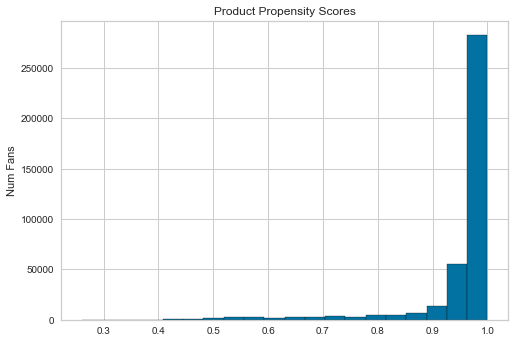

In [20]:
plt.hist(new_predictions["Score"], bins=20, edgecolor='black')
plt.title("Product Propensity Scores")
plt.ylabel("Num Fans")
plt.show()

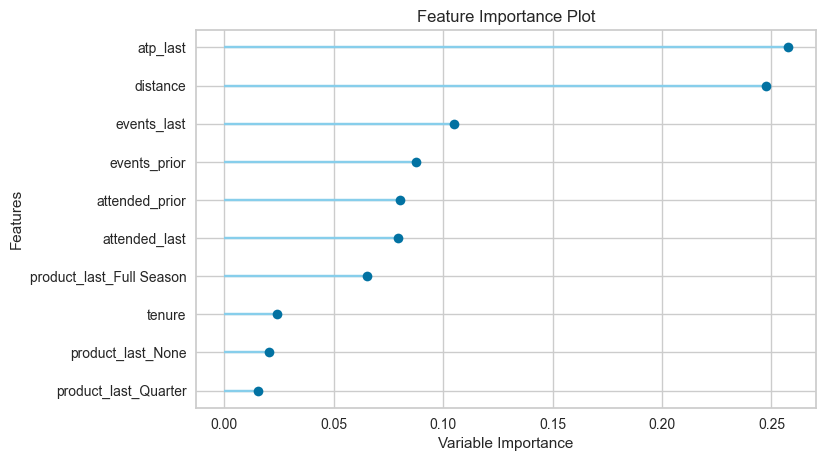

In [21]:
plot_model(final_model, plot='feature')

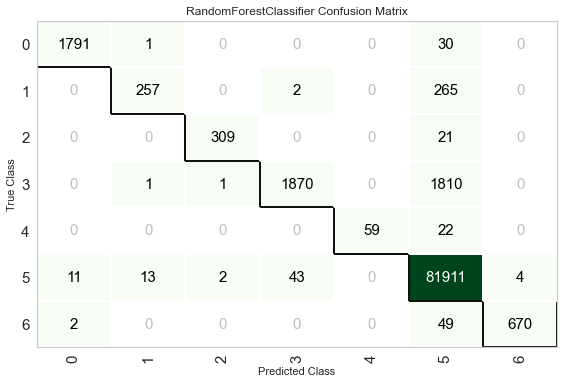

In [22]:
plot_model(final_model, plot='confusion_matrix')

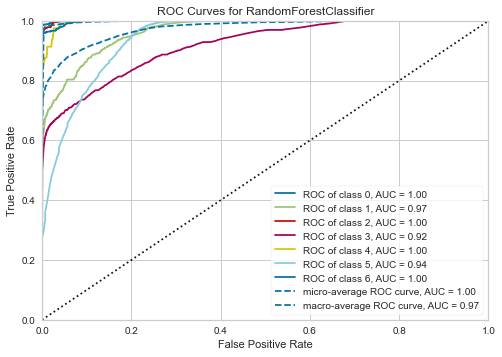

In [23]:
plot_model(final_model, plot='auc')

## Observations for using Canucks data

1. How accurate was this model? 
* The accuracy is 92% (1% lower than using NHL data)

2. How does the prediction looks for each package?
* None:          383191
* Individual:      2781
* Full Season:     2745
* Quarter:          997
* Half Season:      430
* Groups:           400
* Mini Pack:         19

3. What were the most important features in making a correct prediction?
* atp_last, distance, events_last are top 3 important features.


### Done